In [26]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.9/539.9 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 10.5 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
loopstructural 1.5.4 requires geostatspy, which is not installed.
loopstructural 1.5.4 requires scikit-fmm, which is not installed.
loopstructural 1.5.4 requires statsmodels, which is not installed.


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import xgboost
import shap

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

ModuleNotFoundError: No module named 'shap'

In [5]:
p_karst_with_controls = gpd.read_file('temp_p_karst_with_controls_5070.shp')
p_karst_with_controls.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29068 entries, 0 to 29067
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    29068 non-null  float64 
 1   tnmid       29068 non-null  object  
 2   metasource  11319 non-null  object  
 3   sourcedata  655 non-null    object  
 4   sourceorig  675 non-null    object  
 5   sourcefeat  0 non-null      float64 
 6   loaddate    29011 non-null  object  
 7   referenceg  174 non-null    object  
 8   areaacres   29068 non-null  float64 
 9   areasqkm    29068 non-null  float64 
 10  states      29068 non-null  object  
 11  huc12       29068 non-null  object  
 12  name        29068 non-null  object  
 13  hutype      29068 non-null  object  
 14  humod       29060 non-null  object  
 15  tohuc       29068 non-null  object  
 16  noncontrib  27978 non-null  float64 
 17  noncontr_1  27898 non-null  float64 
 18  globalid    29068 non-null  object  
 

In [6]:
p_karst_with_controls.keys()

Index(['objectid', 'tnmid', 'metasource', 'sourcedata', 'sourceorig',
       'sourcefeat', 'loaddate', 'referenceg', 'areaacres', 'areasqkm',
       'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc', 'noncontrib',
       'noncontr_1', 'globalid', 'shape_Leng', 'shape_Area', 'p_karst',
       'mean annua', 'annual pre', 'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 'dominant_r',
       'exposure_i', 'huc_carb_i', 'huc_pct_ar', 'median_slo', 'max_elev',
       'min_elev', 'f_steep', 'geometry'],
      dtype='object')

In [7]:
XY = p_karst_with_controls.loc[:, ['mean annua', 'annual pre', 'precipitat', 'net primar', 
                                   'cmi mean', 'carbonate', 'clay', 'ph', 'sand', 'silt', 
                                    'exposure_i', 'huc_carb_i',  'median_slo', 'max_elev',
                                    'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['mean annua', 'annual pre', 'precipitat', 'net primar', 
                                   'cmi mean', 'carbonate', 'clay', 'ph', 'sand', 'silt', 
                                    'exposure_i', 'huc_carb_i',  'median_slo', 'max_elev',
         ]]


#Y = np.log10(XY.p_karst)
#X['dominant_r'] = X['dominant_r'].astype('category')
Y = XY.p_karst > 0
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29063 entries, 0 to 29067
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean annua  29063 non-null  float64
 1   annual pre  29063 non-null  float64
 2   precipitat  29063 non-null  float64
 3   net primar  29063 non-null  float64
 4   cmi mean    29063 non-null  float64
 5   carbonate   29063 non-null  float64
 6   clay        29063 non-null  float64
 7   ph          29063 non-null  float64
 8   sand        29063 non-null  float64
 9   silt        29063 non-null  float64
 10  exposure_i  29063 non-null  float64
 11  huc_carb_i  29063 non-null  float64
 12  median_slo  29063 non-null  float64
 13  max_elev    29063 non-null  float64
dtypes: float64(14)
memory usage: 3.3 MB


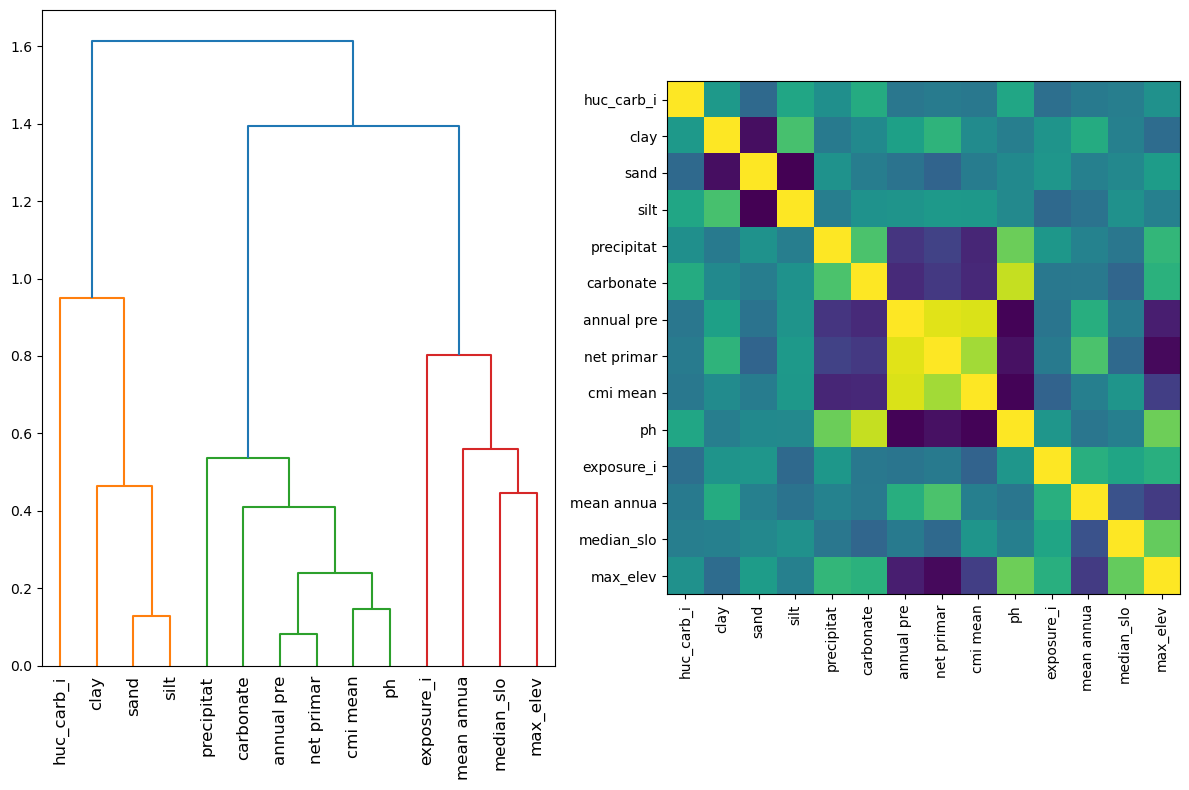

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [20]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]
X_sel = X[selected_features_names]
selected_features_names

Index(['mean annua', 'annual pre', 'precipitat', 'clay', 'exposure_i',
       'huc_carb_i', 'median_slo'],
      dtype='object')

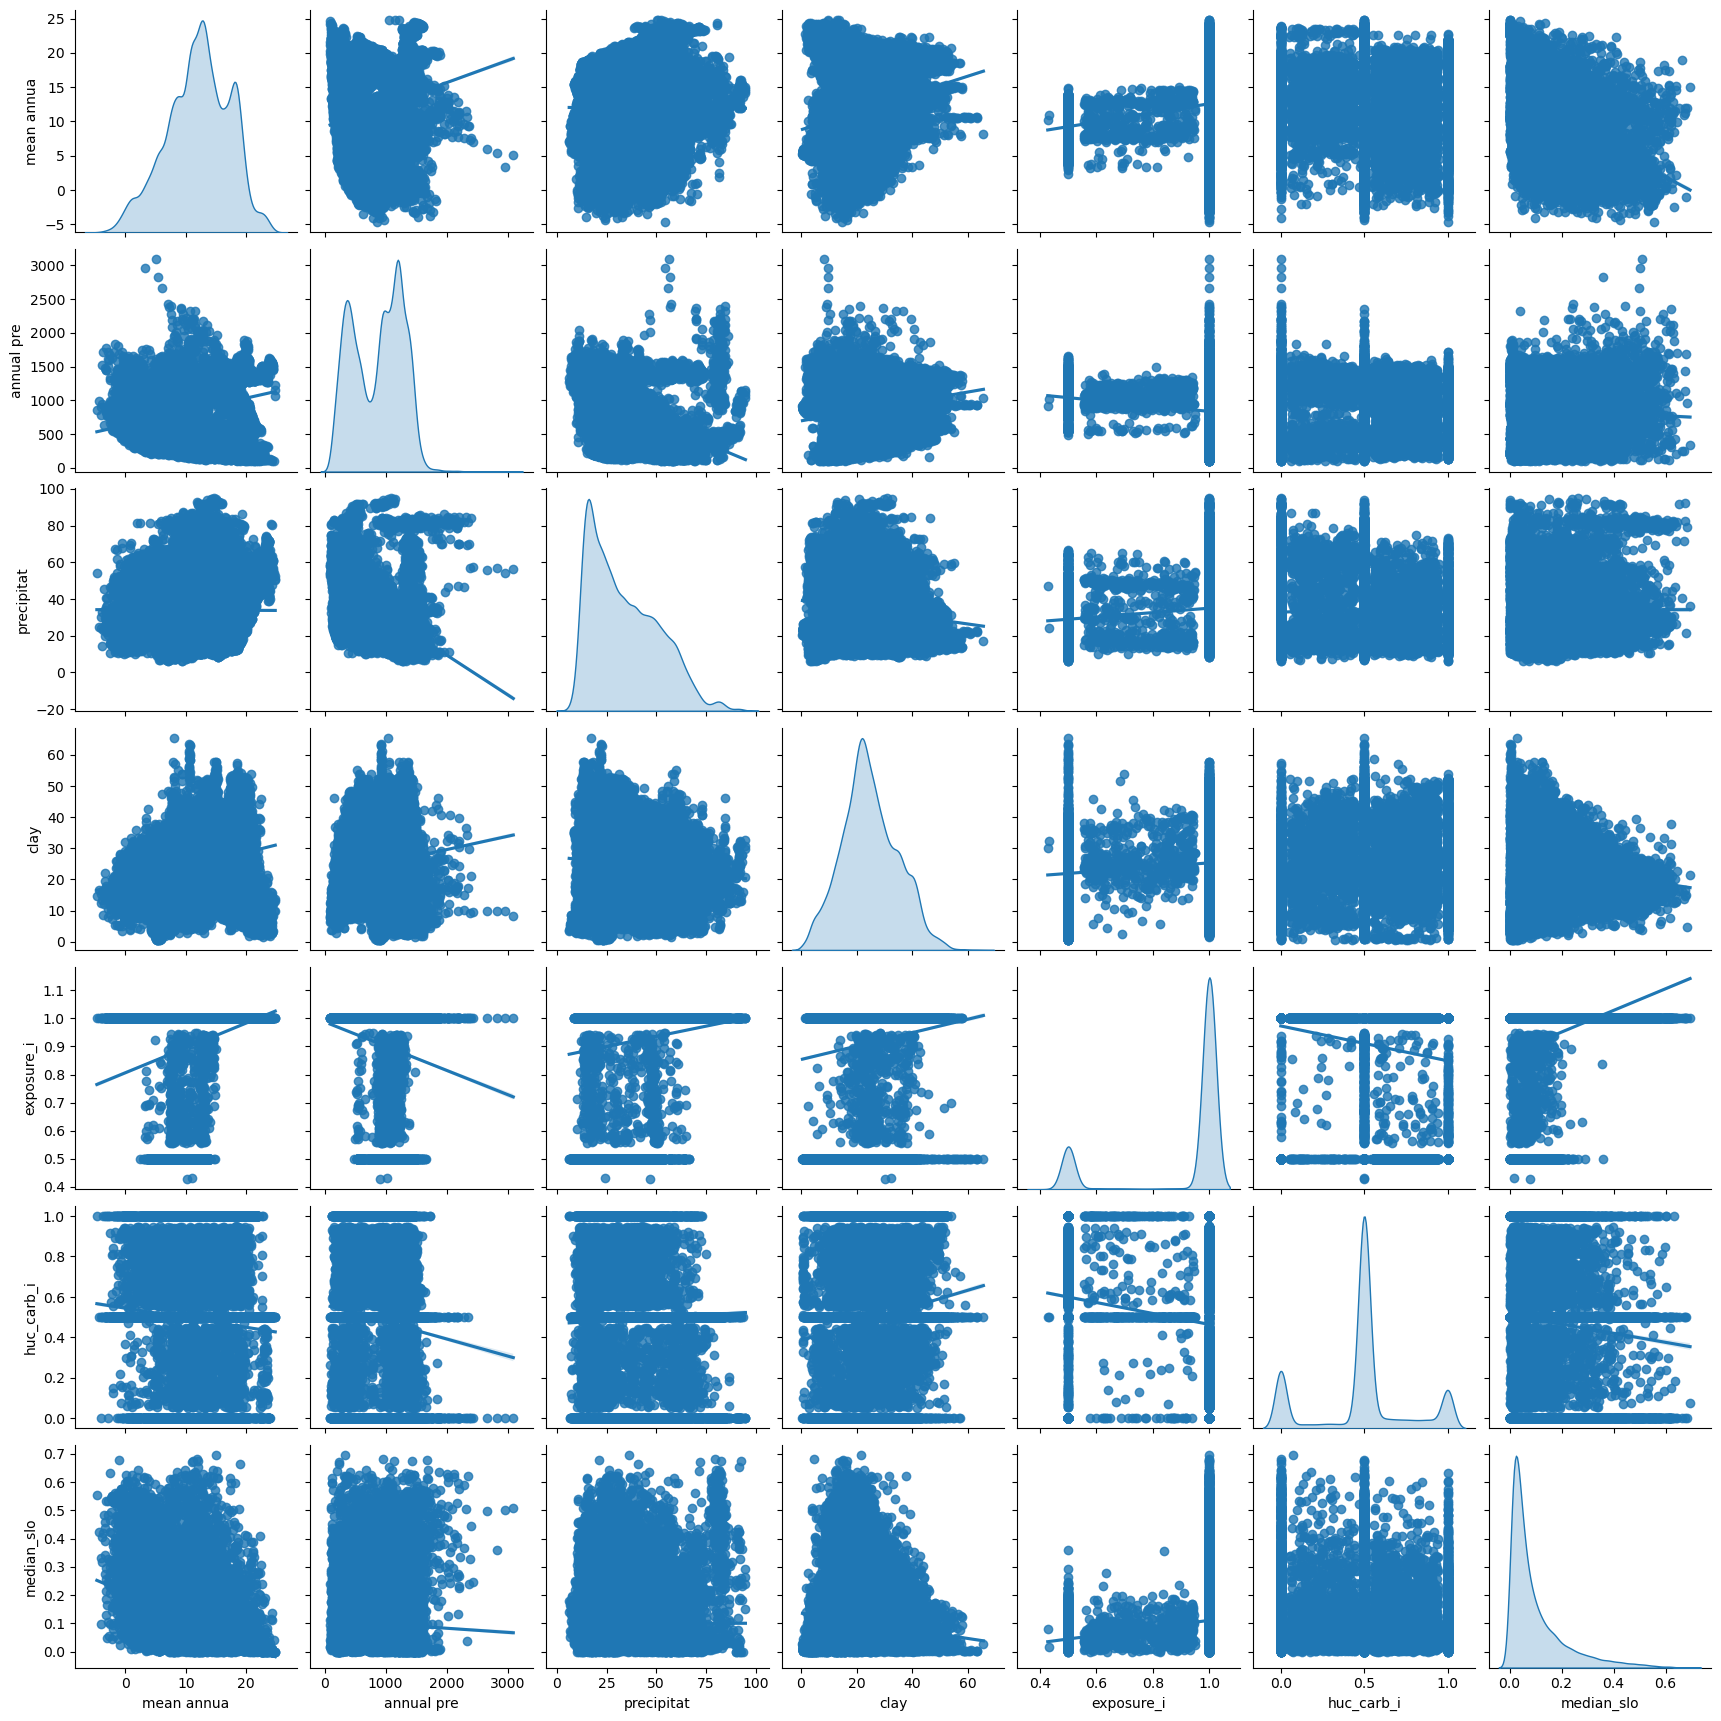

In [21]:
sns.pairplot(X_sel, kind="reg", diag_kind='kde')

In [22]:
clf = xgboost.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
clf.fit(X_train_sel,y_train, eval_set = [(X_test_sel, y_test)])

[0]	validation_0-logloss:0.42848
[1]	validation_0-logloss:0.39688
[2]	validation_0-logloss:0.37973
[3]	validation_0-logloss:0.36795
[4]	validation_0-logloss:0.35986
[5]	validation_0-logloss:0.35487
[6]	validation_0-logloss:0.35143
[7]	validation_0-logloss:0.34774
[8]	validation_0-logloss:0.34580
[9]	validation_0-logloss:0.34462
[10]	validation_0-logloss:0.34321
[11]	validation_0-logloss:0.34215
[12]	validation_0-logloss:0.33936
[13]	validation_0-logloss:0.33824
[14]	validation_0-logloss:0.33812
[15]	validation_0-logloss:0.33661
[16]	validation_0-logloss:0.33593
[17]	validation_0-logloss:0.33511
[18]	validation_0-logloss:0.33270
[19]	validation_0-logloss:0.33231
[20]	validation_0-logloss:0.33103
[21]	validation_0-logloss:0.33051
[22]	validation_0-logloss:0.32900
[23]	validation_0-logloss:0.32800
[24]	validation_0-logloss:0.32712
[25]	validation_0-logloss:0.32696
[26]	validation_0-logloss:0.32701
[27]	validation_0-logloss:0.32683
[28]	validation_0-logloss:0.32655
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
clf.score(X_test_sel, y_test)

0.8678777869529315

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

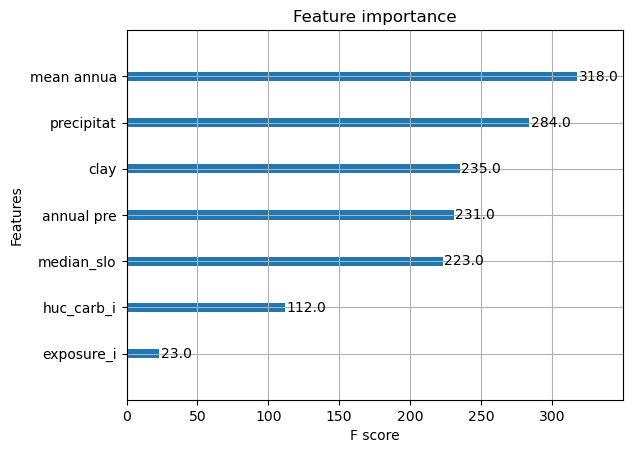

In [24]:
xgboost.plot_importance(clf)

In [29]:
X500 = shap.utils.sample(X_train_sel, 500)
explainer = shap.Explainer(clf.predict, X500)
Exp = explainer(X_test_sel)

ExactExplainer explainer: 7267it [01:07, 89.93it/s]                           


In [34]:
clustering = shap.utils.hclust(X_train_sel, y_train)

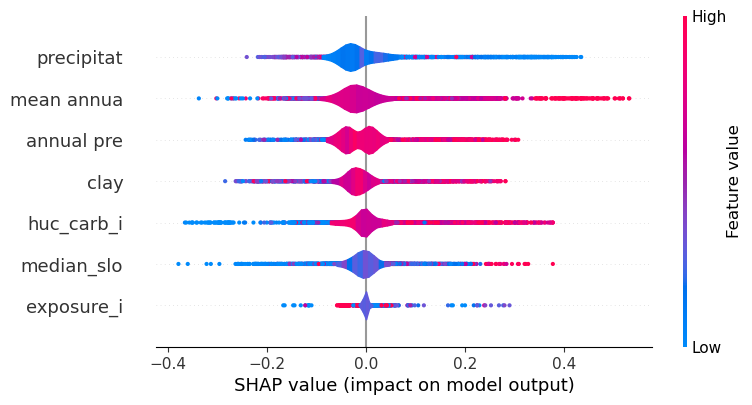

In [31]:
shap.plots.violin(Exp)

In [47]:
Exp

.values =
array([[-3.91666667e-02, -4.16666667e-02, -2.78333333e-02, ...,
        -2.50000000e-03, -3.66666667e-03,  3.33333333e-03],
       [ 1.50000000e-02, -4.55000000e-02, -4.55000000e-02, ...,
        -2.33333333e-03, -1.66666667e-04, -7.33333333e-03],
       [-4.70476190e-02,  2.61904762e-03, -3.98809524e-02, ...,
        -2.14285714e-04, -8.80952381e-04,  1.44523810e-02],
       ...,
       [ 5.95238095e-04,  1.26190476e-03,  1.40952381e-02, ...,
         1.52619048e-02, -3.90476190e-03, -1.40071429e-01],
       [-2.55238095e-02, -2.63571429e-02, -2.03571429e-02, ...,
         1.42857143e-04, -2.15238095e-02, -4.52380952e-03],
       [ 1.18880952e-01,  9.85476190e-02,  3.12047619e-01, ...,
         3.12142857e-02,  6.35476190e-02,  9.25476190e-02]])

.base_values =
array([0.12, 0.12, 0.12, ..., 0.12, 0.12, 0.12])

.data =
array([[2.15666667e+00, 4.02373333e+02, 4.36066667e+01, ...,
        1.00000000e+00, 5.00000000e-01, 2.93241918e-01],
       [1.35120690e+01, 3.68206897e+02, 7

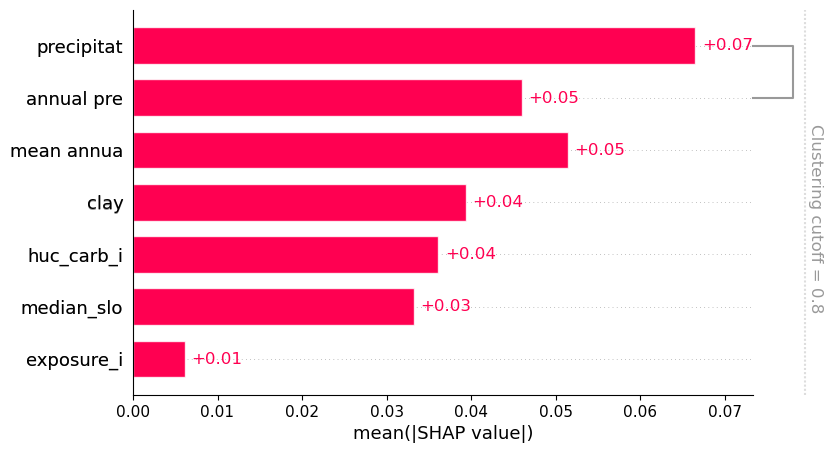

In [40]:
shap.plots.bar(Exp, clustering=clustering, clustering_cutoff=0.8)

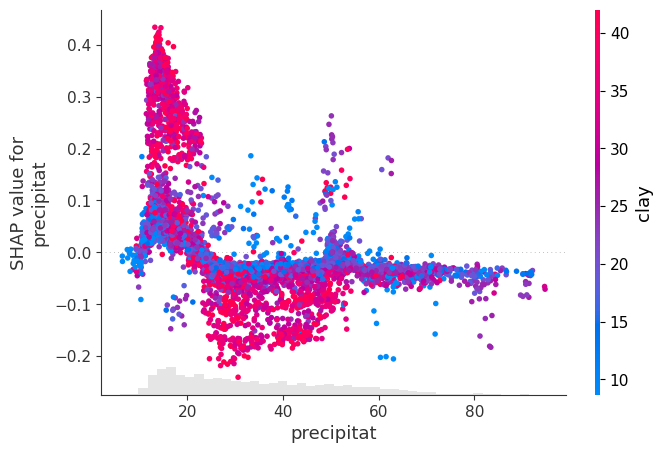

In [41]:
shap.plots.scatter(Exp[:,"precipitat"], color=Exp)

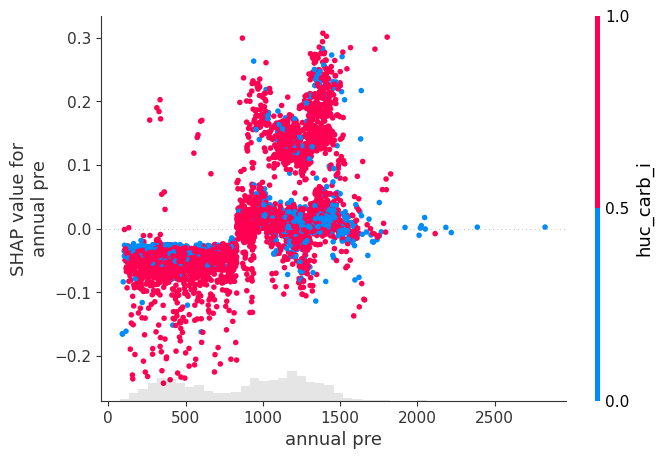

In [44]:
shap.plots.scatter(Exp[:,"annual pre"], color=Exp)

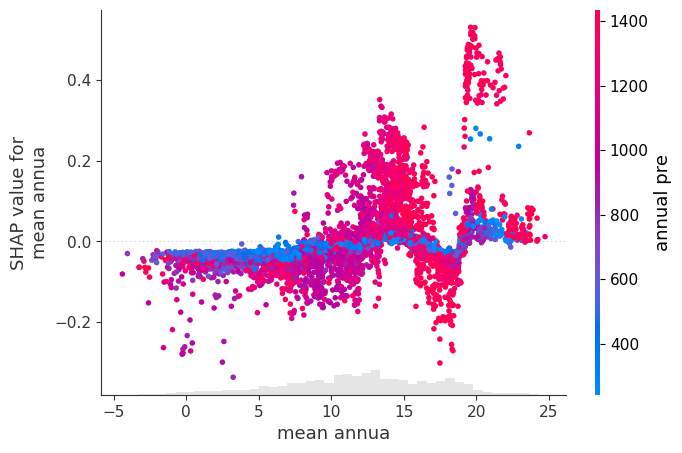

In [42]:
shap.plots.scatter(Exp[:,"mean annua"], color=Exp)


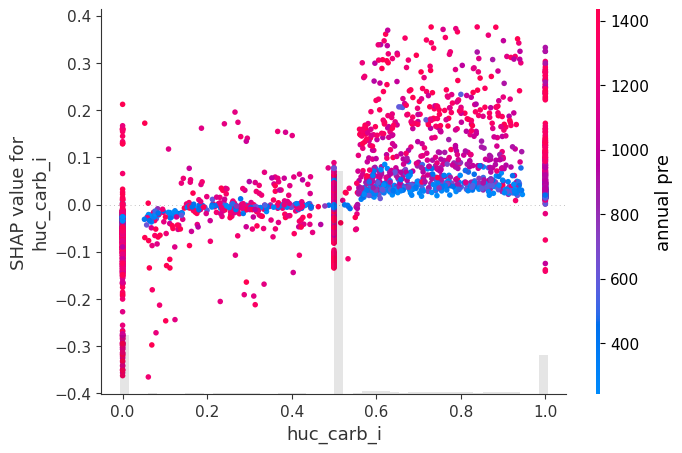

In [43]:
shap.plots.scatter(Exp[:,"huc_carb_i"], color=Exp)

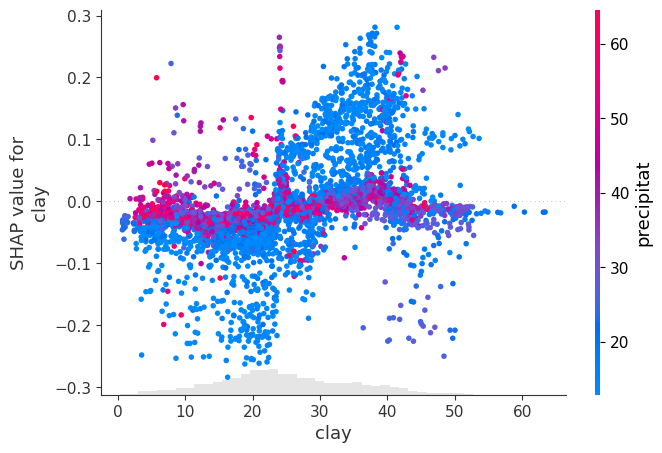

In [45]:
shap.plots.scatter(Exp[:,"clay"], color=Exp)

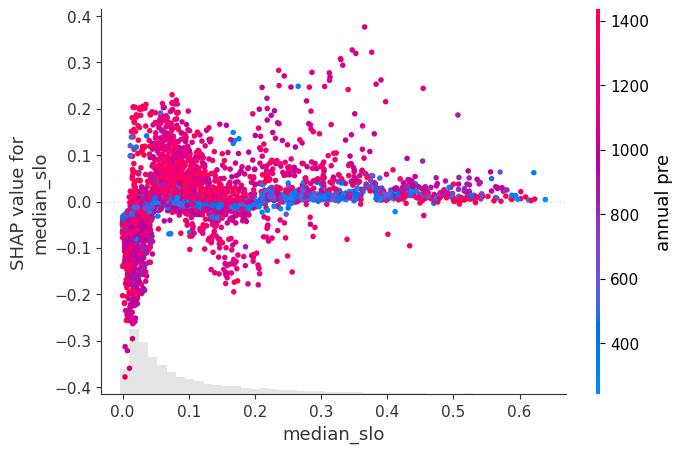

In [46]:
shap.plots.scatter(Exp[:,"median_slo"], color=Exp)